In [1]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
all_seasons = []

for season in range(2023, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
     playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600         Ryan Suter            D           82       15        0   
1     8470604        Jeff Carter            C           72        4        0   
2     8470610        Zach Parise            L           30        5        0   
3     8470613        Brent Burns            D           82       33        0   
4     8470621        Corey Perry            R           54       10        0   
..        ...                ...          ...          ...      ...      ...   
919   8484314       Jiri Smejkal            L           20        1        0   
920   8484321  Nikolas Matinpalo            D            4        0        0   
921   8484325    Waltteri Merela            C           19        0        0   
922   8484326        Patrik Koch            D            1        0        0   
923   8484911        Collin Graf            R            7        2      

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,Jeff Carter,72,4,3,3,11,90,11.45,134,95,53,9,175,18
3,Joe Pavelski,82,7,4,10,27,194,28.18,261,232,130,7,329,34
4,Alex Ovechkin,79,7,2,7,31,272,29.89,395,245,83,17,605,64
5,Evgeni Malkin,82,3,6,6,27,199,23.56,280,218,82,6,401,47
7,Sidney Crosby,82,8,6,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,Logan Cooley,82,2,2,8,20,151,16.52,217,147,57,8,284,21
556,Juraj Slafkovsky,82,2,4,5,20,152,21.56,226,198,98,5,314,27
564,Andrei Kuzmenko,72,3,5,6,22,121,19.29,197,182,97,4,265,40
566,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning
0,8470604,Jeff Carter,C,72,4,0,4,754.2361,4
1,8470794,Joe Pavelski,C,82,40,1,4,1008.5609,3
2,8471214,Alex Ovechkin,L,79,34,1,5,1153.2658,4
3,8471215,Evgeni Malkin,C,82,40,0,2,1115.0731,2
4,8471675,Sidney Crosby,C,82,52,0,3,1205.2073,3
...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,948.8902,1
312,8483515,Juraj Slafkovsky,L,82,30,0,2,1076.1463,2
313,8483808,Andrei Kuzmenko,L,72,24,1,4,893.0555,3
314,8484144,Connor Bedard,C,68,39,1,2,1187.0000,1


In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,GP,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,8470604,Jeff Carter,C,72,4,0,4,754.2361,4,72,...,3,11,90,11.45,134,95,53,9,175,18
1,8470794,Joe Pavelski,C,82,40,1,4,1008.5609,3,82,...,10,27,194,28.18,261,232,130,7,329,34
2,8471214,Alex Ovechkin,L,79,34,1,5,1153.2658,4,79,...,7,31,272,29.89,395,245,83,17,605,64
3,8471215,Evgeni Malkin,C,82,40,0,2,1115.0731,2,82,...,6,27,199,23.56,280,218,82,6,401,47
4,8471675,Sidney Crosby,C,82,52,0,3,1205.2073,3,82,...,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,948.8902,1,82,...,8,20,151,16.52,217,147,57,8,284,21
312,8483515,Juraj Slafkovsky,L,82,30,0,2,1076.1463,2,82,...,5,20,152,21.56,226,198,98,5,314,27
313,8483808,Andrei Kuzmenko,L,72,24,1,4,893.0555,3,72,...,6,22,121,19.29,197,182,97,4,265,40
314,8484144,Connor Bedard,C,68,39,1,2,1187.0000,1,68,...,9,22,206,23.82,299,226,69,17,401,34


In [12]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created]
Index: []

[0 rows x 22 columns]


In [13]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [14]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [15]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [16]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
205,Auston Matthews,18.15,1.0
138,Sam Reinhart,15.49,2.0
150,David Pastrnak,13.78,3.0
166,Kyle Connor,12.92,4.0
197,Kirill Kaprizov,12.80,5.0
193,Artemi Panarin,12.20,6.0
96,Filip Forsberg,11.95,7.0
139,Leon Draisaitl,11.48,8.0
124,Nathan MacKinnon,11.22,9.0
169,Jack Eichel,11.11,10.0


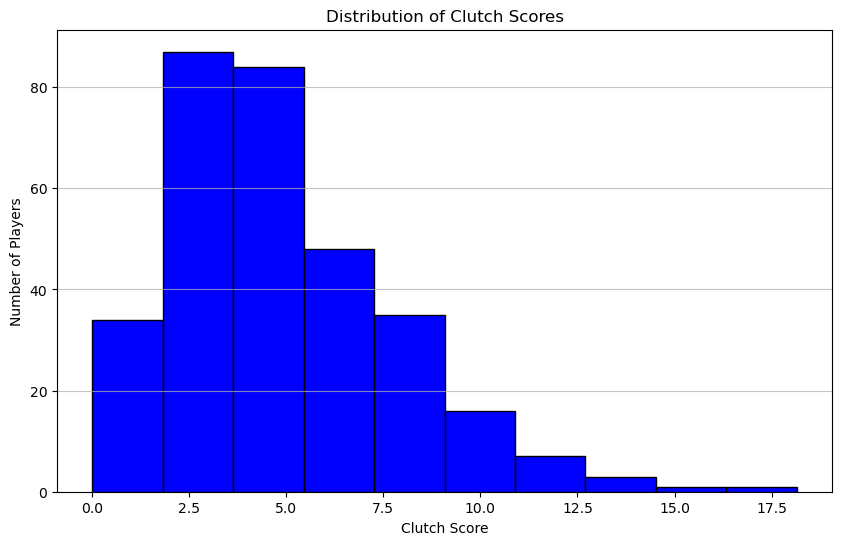

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

In [18]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [19]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    268
1     48
Name: count, dtype: int64

In [20]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.048097
score_time        0.021732
test_accuracy     0.876915
test_precision    0.700635
test_recall       0.590000
test_f1           0.581984
dtype: float64

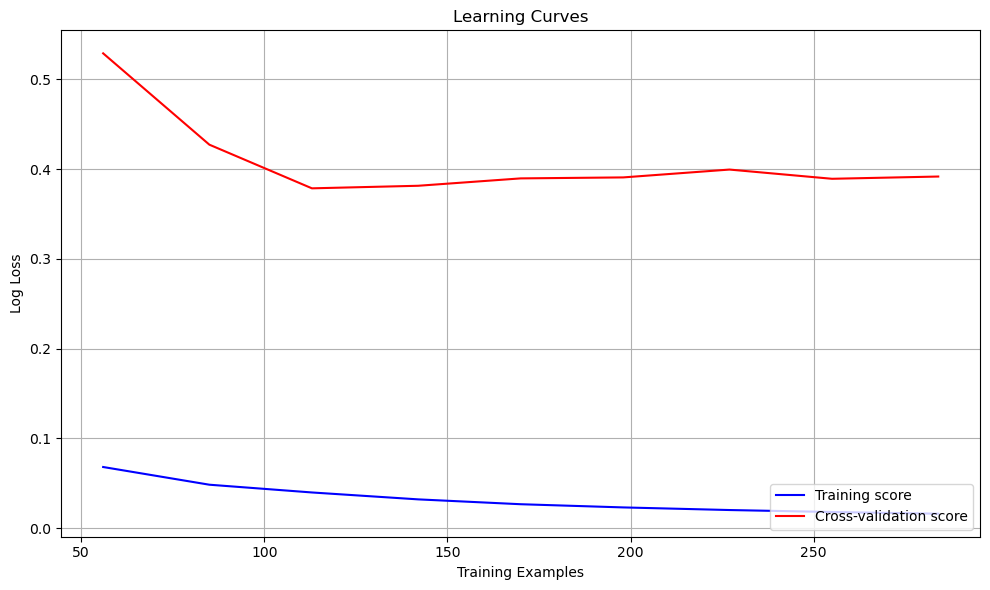

In [22]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

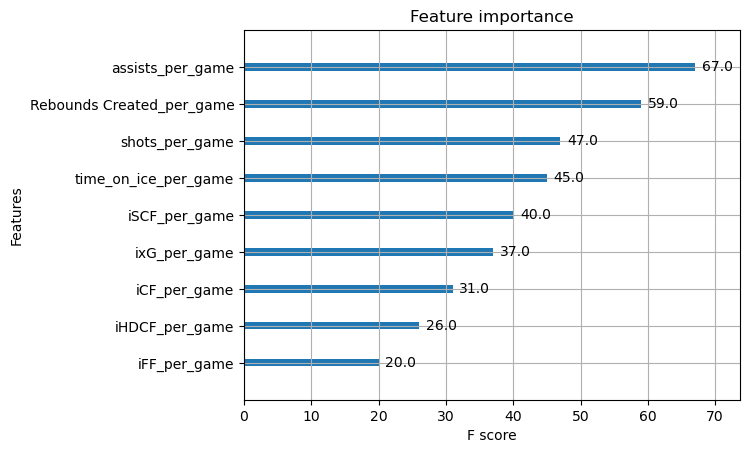

In [23]:
plot_importance(xgb_model)
plt.show()

In [24]:
x_var_adjusted = ['shots_per_game', 'ixG_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var_adjusted]

In [25]:
param_grid = {
    'max_depth': Integer(2,5),
    'min_child_weight': Integer(2,3), 
    'n_estimators': Integer(200, 300),
    'learning_rate': Real(0.03, 0.04), 
    'reg_alpha': Real(0.75, 1.9),
    'reg_lambda': Real(0.75, 1.9),
    'subsample': Real(0.7, 1), 
    'colsample_bytree': Real(0.7, 1)  
}

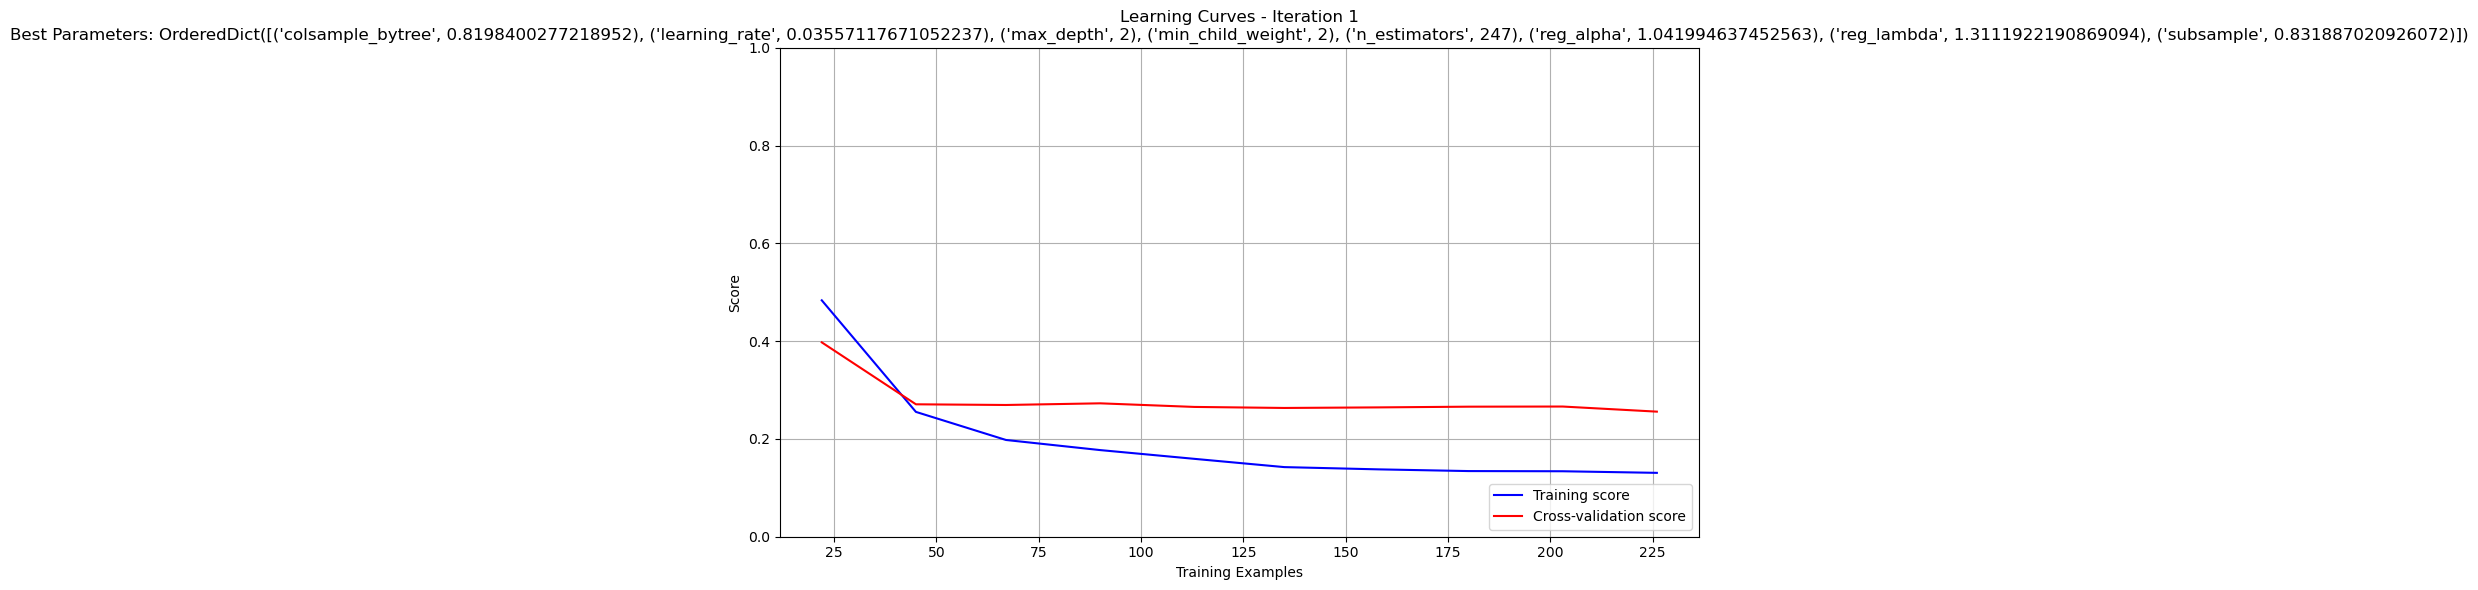

Recall Score:  0.7


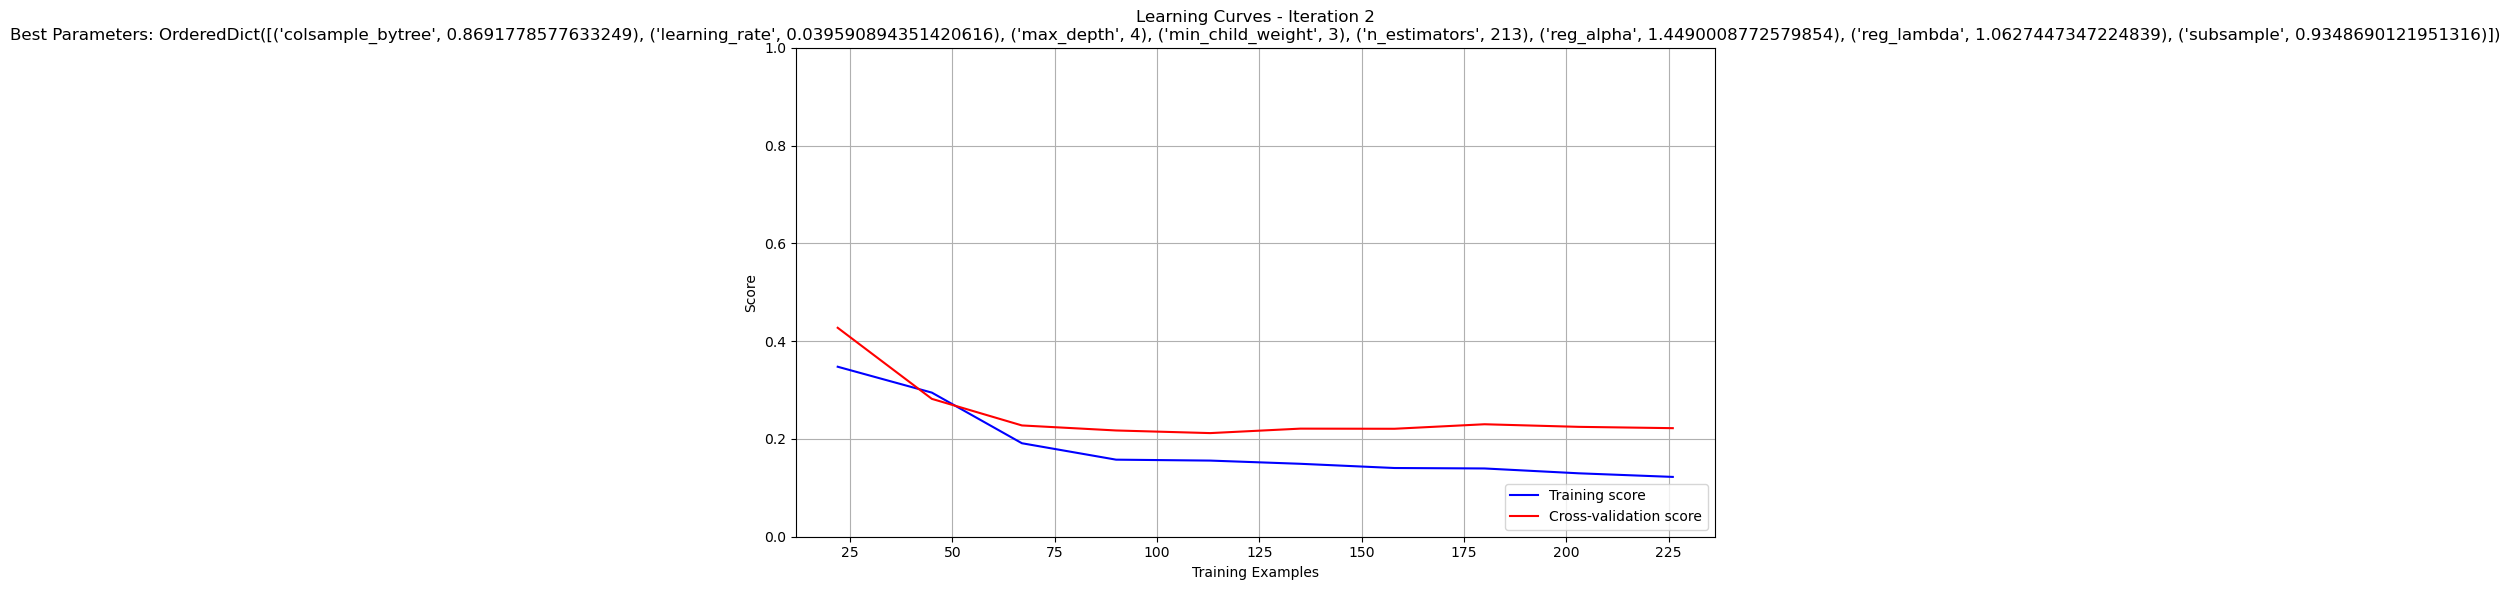

Recall Score:  0.5
Average Accuracy: 0.9140625
Average Precision: 0.7946428571428572
Average Recall: 0.6
Average F1 Score: 0.6830065359477123
Averaged Hyperparameters:
colsample_bytree      0.844509
learning_rate         0.037581
max_depth             3.000000
min_child_weight      2.500000
n_estimators        230.000000
reg_alpha             1.245498
reg_lambda            1.186968
subsample             0.883378
dtype: float64


In [26]:
cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(2):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("Recall Score: ", recall)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

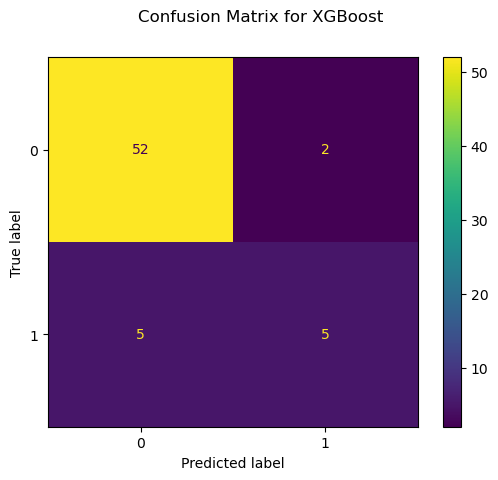

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [28]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.811868
ixG_per_game                 0.799347
iFF_per_game                 0.819012
iSCF_per_game                0.820075
iHDCF_per_game               0.608481
assists_per_game             0.662297
iCF_per_game                 0.806047
Rebounds Created_per_game    0.674669
time_on_ice_per_game         0.712183
dtype: float64


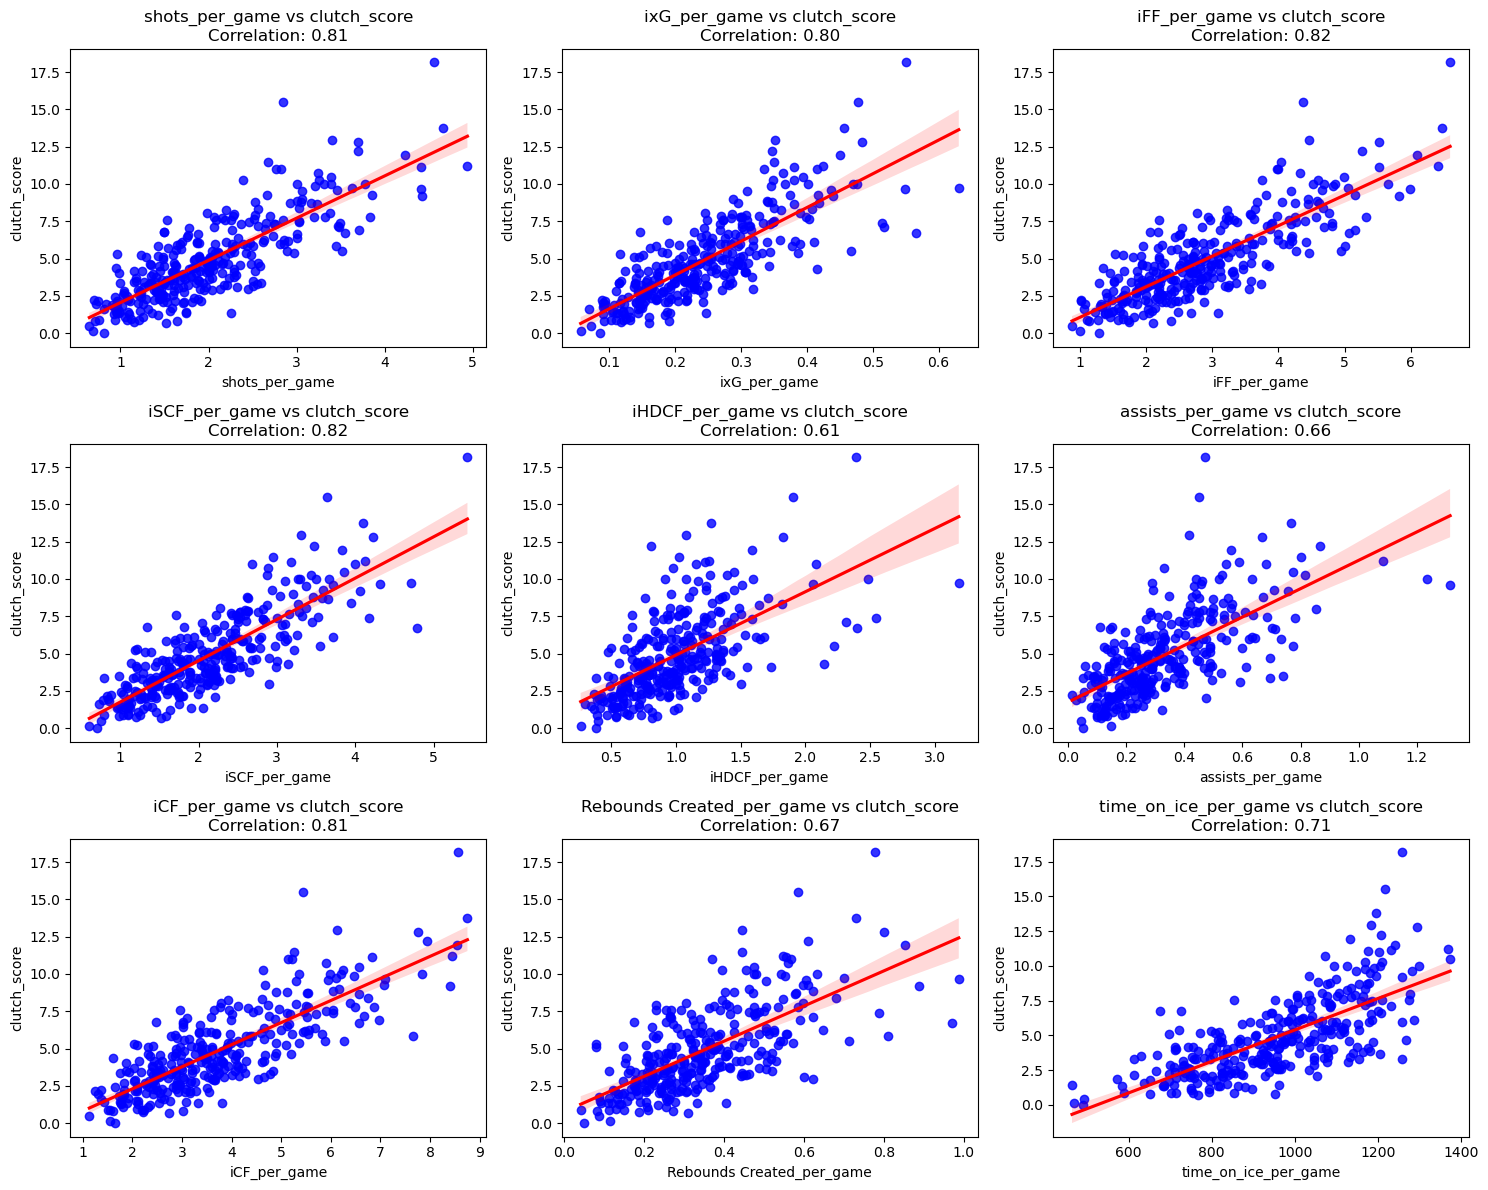

In [29]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

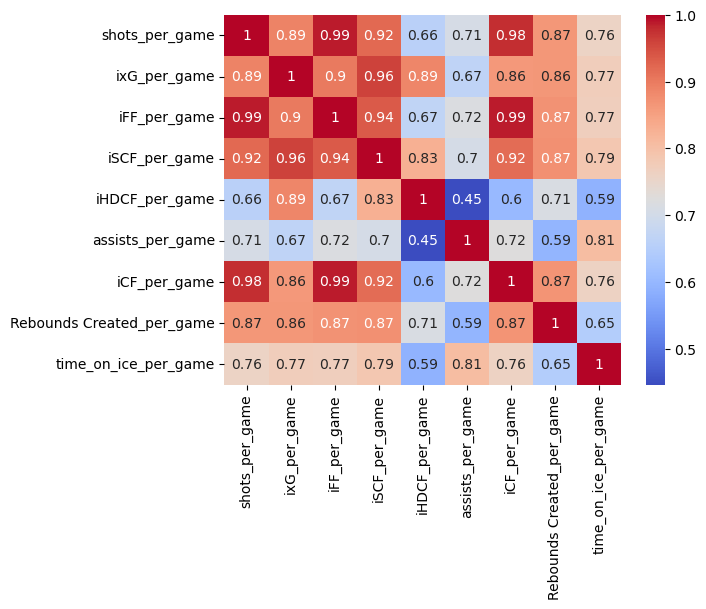

In [30]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [31]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  2.5187831376864036
RMSE:  1.5870674647558003
MAE:  1.0231154937295852
R²:  0.6887655879435518
Adjusted R²:  0.6771907544373202


In [32]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')


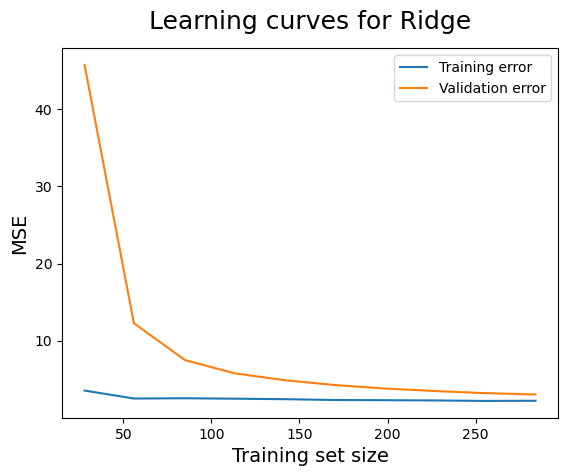

In [33]:
import matplotlib.pyplot as plt

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

In [34]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                  Player  Actual  Predicted     Error
166          Kyle Connor   12.92   8.233792  4.686208
203      Matthew Tkachuk    5.50   9.315262  3.815262
111        Jake Guentzel    6.72  10.336777  3.616777
139       Leon Draisaitl   11.48   7.947920  3.532080
57         Ryan Johansen    5.24   2.306277  2.933723
193       Artemi Panarin   12.20   9.525025  2.674975
28         Kyle Palmieri    9.27   6.762177  2.507823
178         Dylan Strome    7.80   5.426185  2.373815
295          Tim Stützle    4.67   7.016215  2.346215
93     Zemgus Girgensons    4.13   1.949169  2.180831
113      Anthony Duclair    6.58   4.400363  2.179637
129            Bo Horvat    9.51   7.455286  2.054714
73          Brandon Saad    6.46   4.413938  2.046062
307       Cole Sillinger    2.86   4.825865  1.965865
158         Sam Lafferty    4.05   2.099019  1.950981
127       Elias Lindholm    3.87   5.737086  1.867086
169          Jack Eichel   11.11   9.295218  1.

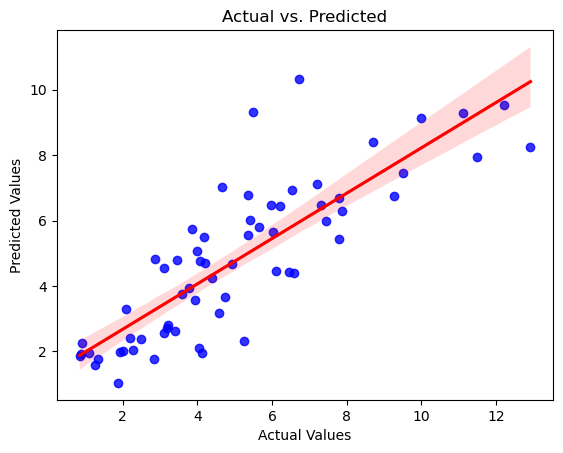

In [35]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

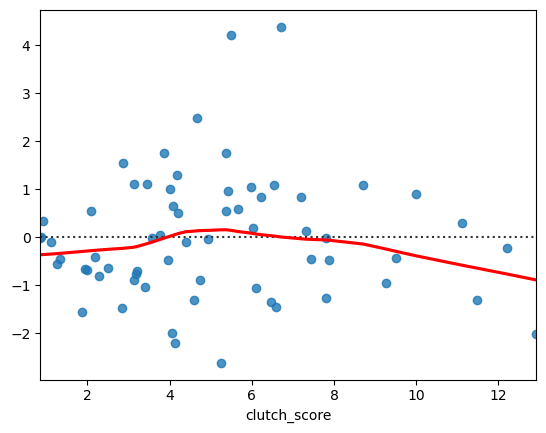

In [36]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

Outliers based on Cook's Distance:
                    Player  Actual  Predicted  Cook's Distance
205        Auston Matthews   18.15  12.634076         0.197544
138           Sam Reinhart   15.49   9.018745         0.105634
166            Kyle Connor   12.92   9.357363         0.036842
197        Kirill Kaprizov   12.80  10.164969         0.018119
193         Artemi Panarin   12.20  10.003641         0.022181
96          Filip Forsberg   11.95   9.460642         0.027349
139         Leon Draisaitl   11.48   8.411420         0.021388
124       Nathan MacKinnon   11.22  12.693385         0.018382
169            Jack Eichel   11.11   9.446364         0.019817
156          Brayden Point   10.99   8.411221         0.021080
88   Jonathan Marchessault   10.73   8.223448         0.017693
82             J.T. Miller   10.25   7.472887         0.020756
129              Bo Horvat    9.51   7.579560         0.013120
276            Jack Hughes    9.19  10.811353         0.014450
188       Joel Eriks

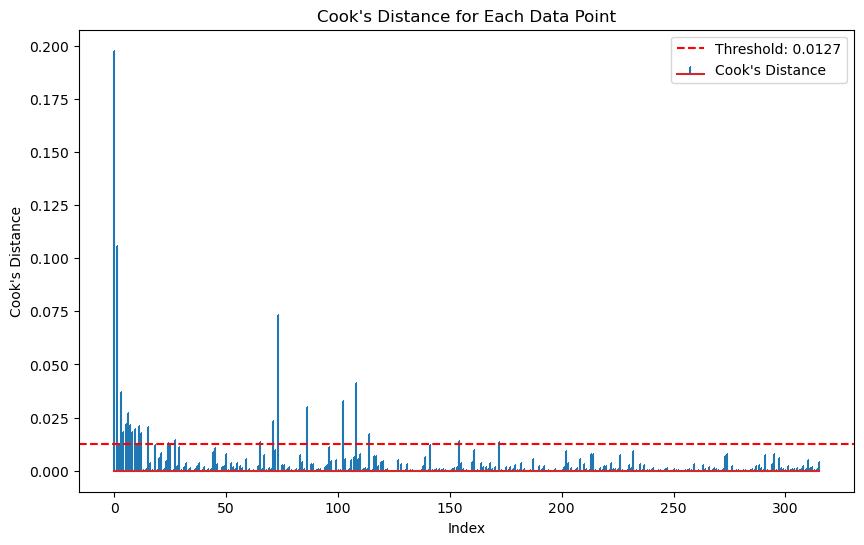

In [37]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


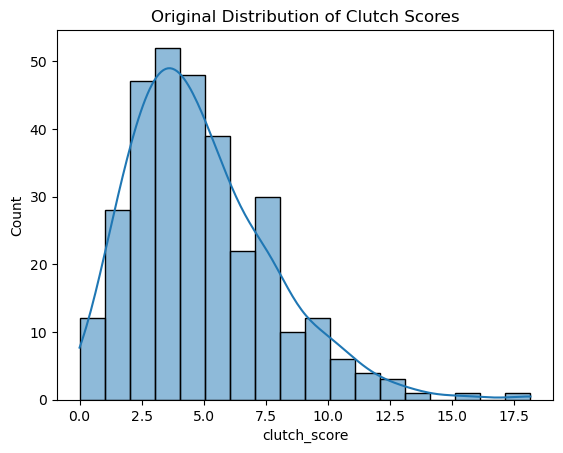

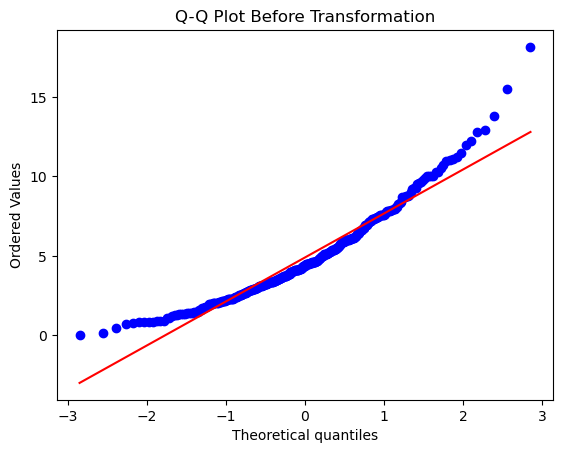

In [38]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

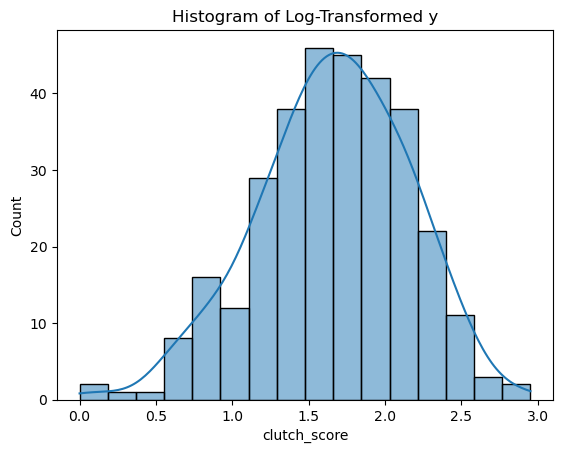

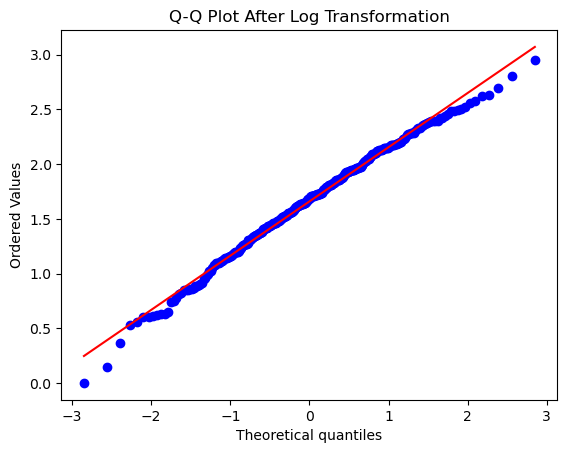

In [39]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [40]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

In [41]:
y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)
y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.07948535779241386
RMSE:  0.281931477122392
MAE:  0.21693378534359875
R²:  0.6715317614435028
Adjusted R²:  0.6593160005054512


In [42]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                  Player    Actual  Predicted     Error
208            Sam Steel  0.647103   1.240756  0.593652
166          Kyle Connor  2.633327   2.047843  0.585484
57         Ryan Johansen  1.830980   1.297687  0.533293
249         Parker Kelly  0.631272   1.158673  0.527401
209         Brett Howden  0.746688   1.234124  0.487436
139       Leon Draisaitl  2.524127   2.040130  0.483998
112      Mattias Janmark  0.615186   1.097913  0.482727
73          Brandon Saad  2.009555   1.575430  0.434126
93     Zemgus Girgensons  1.635106   1.220745  0.414361
158         Sam Lafferty  1.619388   1.206565  0.412824
193       Artemi Panarin  2.580217   2.181118  0.399099
113      Anthony Duclair  2.025513   1.643523  0.381990
203      Matthew Tkachuk  1.871802   2.250979  0.379177
28         Kyle Palmieri  2.329227   1.964820  0.364407
9            Kyle Okposo  1.128171   1.483875  0.355704
192       Evan Rodrigues  1.415853   1.754304  0.338451
129          

Outliers based on Cook's Distance:
                  Player    Actual  Predicted  Cook's Distance
223      Michael Carcone  2.048982   1.196409         0.046285
272       Nils Hoglander  2.047693   1.491492         0.016856
111        Jake Guentzel  2.043814   2.488178         0.016061
203      Matthew Tkachuk  1.871802   2.221522         0.013934
278      Simon Holmstrom  1.845300   1.146939         0.023142
48      Evgeny Kuznetsov  1.118415   1.597562         0.015408
214          Noah Gregor  0.887891   1.376908         0.014379
116           Miles Wood  0.854415   1.629894         0.014474
183  Anthony Beauvillier  0.845868   1.454169         0.014990
112      Mattias Janmark  0.615186   1.137521         0.016380
213       Taylor Raddysh  0.598837   1.442391         0.021889
221     Michael Pezzetta  0.148420   0.551509         0.034277
41   Nicolas Deslauriers  0.000000   0.728208         0.084302


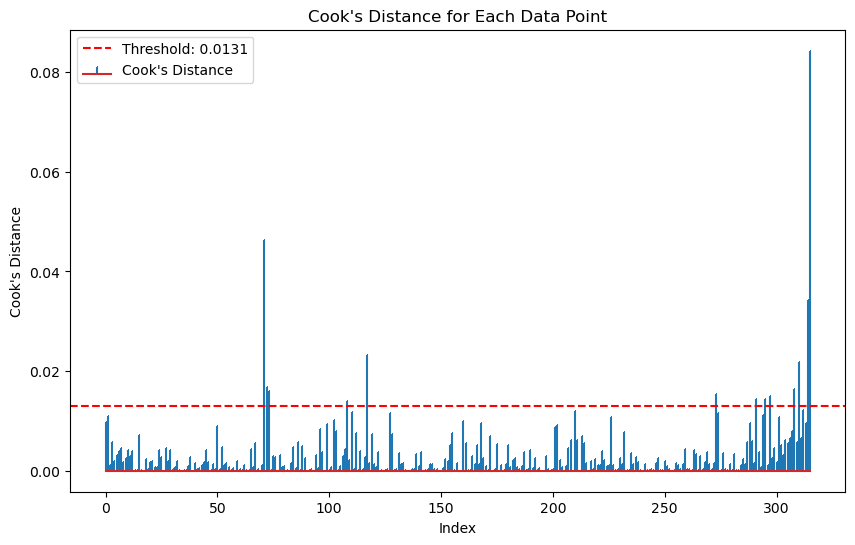

In [43]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

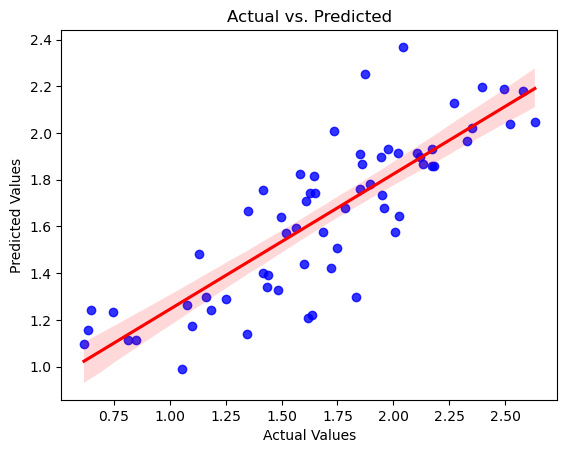

In [44]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

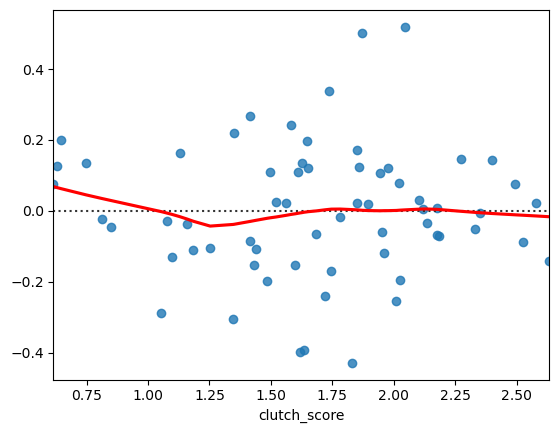

In [45]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))